In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


class HyperTreeSVM:
    def __init__(self, tree_depth, svm_kernel, svm_C):
        self.tree_depth = tree_depth
        self.svm_kernel = svm_kernel
        self.svm_C = svm_C

    def fit(self, X, y):
        self.clf_tree = DecisionTreeClassifier(max_depth=self.tree_depth)
        self.clf_tree.fit(X, y)

        leaf_indices = np.where(self.clf_tree.apply(X) == -1)[0]
        self.leaves_id = {i: leaf_id for leaf_id, i in enumerate(leaf_indices)}
        self.leaves_counter = len(self.leaves_id)

        self.clf_svm = []
        for leaf_id in range(self.leaves_counter):
            node_id = list(self.leaves_id.values())[leaf_id]
            leaf_indices = np.where(self.clf_tree.apply(X) == node_id)
            X_leaf, y_leaf = X[leaf_indices], y[leaf_indices]
            
            clf_svm_leaf = SVC(kernel=self.svm_kernel, C=self.svm_C)
            clf_svm_leaf.fit(X_leaf, y_leaf)
            self.clf_svm.append(clf_svm_leaf)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(self.leaves_counter):
            node_id = list(self.leaves_id.values())[i]
            leaf_indices = np.where(self.clf_tree.apply(X) == node_id)
            y_pred[leaf_indices] = self.clf_svm[i].predict(X[leaf_indices])
        return y_pred


In [3]:
# Load the updated dataset
df = pd.read_csv('nseinew.csv')

# Extract independent variables (X) and target variable (y)
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['signal']

In [4]:
# DecisionTreeClassifier does not accept missing values encoded as NaN.
# Handle missing values in X
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Create and fit the hybrid model
model = HyperTreeSVM(tree_depth=5, svm_kernel='linear', svm_C=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

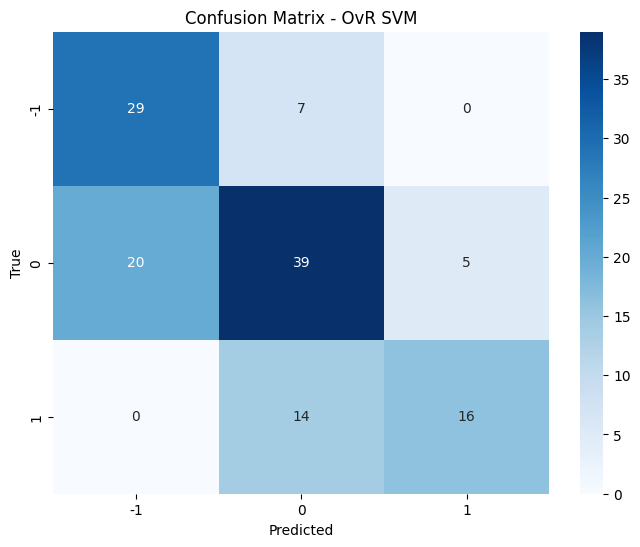

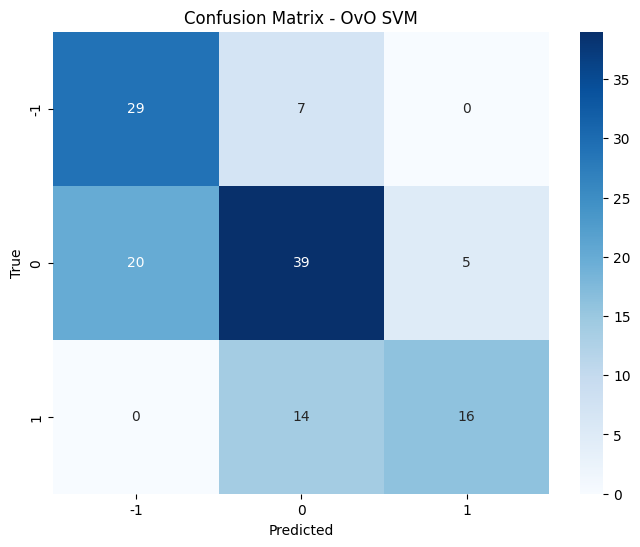

Multi-class SVM (OvR) Accuracy: 0.6461538461538462

Multi-class SVM (OvR) Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.81      0.68        36
           0       0.65      0.61      0.63        64
           1       0.76      0.53      0.63        30

    accuracy                           0.65       130
   macro avg       0.67      0.65      0.65       130
weighted avg       0.66      0.65      0.64       130


Multi-class SVM (OvO) Accuracy: 0.6461538461538462

Multi-class SVM (OvO) Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.81      0.68        36
           0       0.65      0.61      0.63        64
           1       0.76      0.53      0.63        30

    accuracy                           0.65       130
   macro avg       0.67      0.65      0.65       130
weighted avg       0.66      0.65      0.64       130



In [6]:
# Train a Multi-class SVM with One-vs-One (OvO) strategy
svm_ovo_classifier = SVC(kernel='linear', decision_function_shape='ovo')  # 'ovo' stands for one-vs-one
svm_ovo_classifier.fit(X_train, y_train)

svm_ovo_predictions = svm_ovo_classifier.predict(X_test)

# Evaluate the classifier
svm_ovo_accuracy = accuracy_score(y_test, svm_ovo_predictions)
svm_ovo_classification_report = classification_report(y_test, svm_ovo_predictions)
svm_ovo_conf_matrix = confusion_matrix(y_test, svm_ovo_predictions)

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(svm_ovo_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - OvO SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print results for OvO
print("\nMulti-class SVM (OvO) Accuracy:", svm_ovo_accuracy)
print("\nMulti-class SVM (OvO) Classification Report:")
print(svm_ovo_classification_report)

# ---------------------------------------------------------------------------------------------

# Train a Decision Tree
decision_tree_classifier = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
decision_tree_classifier.fit(X_train, y_train)

# Predictions
decision_tree_predictions = decision_tree_classifier.predict(X_test)

# Evaluate the classifiers
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_classification_report = classification_report(y_test, decision_tree_predictions)

# Print results
print("Decision Tree Accuracy:", decision_tree_accuracy*100)
print('HKSVM Accuracy:', accuracy_score(y_test, y_pred)*100)

print("\nDecision Tree Classification Report:")
print(decision_tree_classification_report)


# ----------------------------------------------------------------------------

# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Confusion matrix for Decision Tree
decision_tree_conf_matrix = confusion_matrix(y_test, decision_tree_predictions)
print("Decision Tree Confusion Matrix:")
print(decision_tree_conf_matrix)

# Plot Decision Tree Confusion Matrix
plot_confusion_matrix(decision_tree_conf_matrix, labels=['Hold', 'Buy', 'Sell'])

# Confusion matrix for HyperTreeSVM
svm_conf_matrix = confusion_matrix(y_test, y_pred)
print("\nHKSVM Confusion Matrix:")
print(svm_conf_matrix)

# Plot HyperTreeSVM Confusion Matrix
plot_confusion_matrix(svm_conf_matrix, labels=['Hold', 'Buy', 'Sell'])

